In [4]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import transformations as t
from mpl_toolkits.mplot3d import Axes3D
import os
import threading


tf.logging.set_verbosity(tf.logging.INFO)

def show_cv2(img):
    # swap b and r channels
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])

    plt.figure(figsize=(15, 15))
    plt.imshow(img)
    plt.show()

def plot_histogram(img):
    color = ('b','g','r')
    for i,col in enumerate(color):
        histr = cv2.calcHist([img],[i],None,[256],[0,256])
        plt.plot(histr,color = col)
        plt.xlim([0,256])
    plt.show()
    
def add_grayscale_noise(img, std_dev):
    noise = np.expand_dims(np.random.normal(0, std_dev, size=img.shape[:2]).astype(np.int8), axis=2)
    img = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)
    return img

def add_colored_noise(img, std_dev):
    noise = np.random.normal(0, std_dev, size=img.shape).astype(np.int8)
    img = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)
    return img


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
def listfiles(path):
    return [os.path.join(dp, f) for dp, dn, fn in os.walk(path) for f in fn]
tag_urls = listfiles("./tags")
scene_urls = listfiles("./places")

print(tag_urls[0], scene_urls[0])

./tags/tag36_11_00142.png ./places/Places365_val_00013979.jpg


In [6]:
# Populate some camera intrinsic settings
# And other constants
# To do: capitolize these variables names idk how to find and replace in this notebook

#camera_intrinsics = [1.1998640834468974e+03, 0, 640.0 / 2, 0, 1.1998640834468974e+03, 480.0 / 2, 0, 0, 1]
camera_intrinsics = [1473.967474, 0.000000, 569.329599, 0.000000, 1473.916904, 379.610277, 0.000000, 0.000000, 1.000000]
camera_intrinsics = np.array(camera_intrinsics).reshape([3, 3])

fx = camera_intrinsics[0,0]
fy = camera_intrinsics[1,1]
cx = camera_intrinsics[0,2]
cy = camera_intrinsics[1,2]

tag_size = 0.1

print(camera_intrinsics)

[[1.47396747e+03 0.00000000e+00 5.69329599e+02]
 [0.00000000e+00 1.47391690e+03 3.79610277e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [7]:
def gen_sample(plot=False, low_res=False):
    #img_scene = np.random.randint(0, 255, size=(768, 1024, 3)).astype(np.uint8)
    white_background = False
    if np.random.randint(20) == 1:
        # Eliminate tag borders sometime to prevent overfitting
        white_background = True

    if not white_background:
        img_scene = cv2.resize(cv2.imread(np.random.choice(scene_urls)), (1280, 720), interpolation=cv2.INTER_NEAREST)

    img_tag = cv2.resize(cv2.imread(np.random.choice(tag_urls)), (200, 200), interpolation=cv2.INTER_NEAREST)

    world_corners = np.array([[-1, -1], [1, -1], [-1, 1], [1, 1]]) * tag_size / 2.0
    pixel_corners = np.array([[0, 0], [1, 0], [0, 1], [1, 1]]) * np.array(img_tag.shape)[:2]

    # Add a Z component and homogeneous coordinate
    corners_3d = np.hstack((world_corners, np.array([[0, 1]] * 4)))

    done = False
    attempts = 0
    while not done:
        # Apply a random rotation to our corners
        angle_lim = np.pi / 2 * 0.7
        #rotation_matrix = t.rotation_matrix(np.random.uniform(-angle_lim, angle_lim), [1, 0, 0])
        #rotation_matrix = rotation_matrix @ t.rotation_matrix(np.random.uniform(-angle_lim, angle_lim), [0, 1, 0])
        rand_vector = t.random_vector(3)
        rand_vector[2]= 0
        rand_vector /= np.linalg.norm(rand_vector)
        rotation_matrix = t.rotation_matrix(np.random.uniform(-angle_lim, angle_lim), rand_vector)
        #rotation_matrix = rotation_matrix @ t.rotation_matrix(np.random.uniform(-np.pi, np.pi), [0, 0, 1])
        corners_3d_rotated = (rotation_matrix @ corners_3d.T).T

        # Translate our corners to a random 3D point within our camera view
        #z = np.random.triangular(0.2, 0.2, 5)
        z = np.random.uniform(0.2, 3.5)
        x = np.random.uniform(-1, 1) * z / fx * cx
        y = np.random.uniform(-1, 1) * z / fy * cy
        translation = np.array([x, y, z])
        translation_matrix = t.translation_matrix(translation)
        corners_3d_transformed = (translation_matrix @ corners_3d_rotated.T).T

        # Project into 2D image space
        projected_transformed = camera_intrinsics @ corners_3d_transformed.T[:3]
        projected_transformed /= projected_transformed[2]
 
        projected_transformed = np.vstack((projected_transformed[0], projected_transformed[1]))
        # print(projected_transformed)

        done = True
        attempts += 1
        for (x, y) in projected_transformed.T:
            # Reject views that have tag corners chopped off
            if x < 0 or y < 0 or x > 1280 or y > 720:
                done = False

    center_x, center_y = np.mean(projected_transformed, axis=1)
    width = np.max(projected_transformed[0]) - np.min(projected_transformed[0])
    height = np.max(projected_transformed[1]) - np.min(projected_transformed[1])

    # print(attempts, "attempt(s)")

    # Compute a homography
    H = cv2.findHomography(pixel_corners, projected_transformed.T)[0]

    # Random lighting condition
    dynamic_range = np.random.uniform(0.4, 1.0)
    color_shift =  (1.0 - dynamic_range) * np.random.uniform(0, 255) + np.random.normal(0.0, 10, size=3)

    img_tag_lighting = img_tag * dynamic_range
    img_tag_lighting += color_shift
    img_tag_lighting = np.clip(img_tag_lighting, 0.0, 255.0).astype(np.uint8)
    
    img_tag_blank = np.zeros(img_tag.shape) + 255.0 * dynamic_range
    img_tag_blank += color_shift
    img_tag_blank = np.clip(img_tag_blank, 0.0, 255.0).astype(np.uint8)
    
    if white_background:
        img_scene = np.clip(np.zeros((720, 1280, 3)) + 255.0 * dynamic_range + color_shift, 0.0, 255.0).astype(np.uint8)
        img_scene = add_colored_noise(img_scene, 4)
        img_scene = add_grayscale_noise(img_scene, 10)
    
    # Some noise
    img_tag_filtered = cv2.GaussianBlur(img_tag_lighting, (3, 3), 0)
    img_tag_filtered = add_colored_noise(img_tag_filtered, 4)
    img_tag_filtered = add_grayscale_noise(img_tag_filtered, 10)
    img_tag_blank = cv2.GaussianBlur(img_tag_blank, (3, 3), 0)
    img_tag_blank = add_colored_noise(img_tag_blank, 4)
    img_tag_blank = add_grayscale_noise(img_tag_blank, 10)
    
    # Overlay warped image
    img_scene_with_tag = np.array(img_scene)
    cv2.warpPerspective(img_tag_filtered, H, dsize=img_scene.shape[:2][::-1], dst=img_scene_with_tag, borderMode=cv2.BORDER_TRANSPARENT)
    
    if np.random.randint(3) == 1:
        # put a blank rectangle on the "to tag" scene for some extra overfitting protection
        cv2.warpPerspective(img_tag_blank, H, dsize=img_scene.shape[:2][::-1], dst=img_scene, borderMode=cv2.BORDER_TRANSPARENT)
    blur_size = np.random.randint(4) * 2 + 1
    img_scene_with_tag = cv2.GaussianBlur(img_scene_with_tag, (blur_size, blur_size), 0)
    img_scene = cv2.GaussianBlur(img_scene, (blur_size, blur_size), 0)

    # Bias our tag's color towards the image average color
    img_tag_filtered = (img_tag_filtered * 49.0 / 50.0 + (np.mean(img_scene,axis=(0,1)) / 50.0).astype(np.int16)).astype(np.uint8)

    # Plot?
    if plot:
        show_cv2(img_tag_filtered)
        
        show_cv2(img_tag_blank)
        
        # Visualize in 3D
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        xs = corners_3d.T[0]
        ys = corners_3d.T[1]
        zs = corners_3d.T[2]
        ax.scatter(xs, ys, zs)

        xs = corners_3d_transformed.T[0]
        ys = corners_3d_transformed.T[1]
        zs = corners_3d_transformed.T[2]
        ax.scatter(xs, ys, zs)

        # Visualize in 3D
        plt.figure()
        plt.ylim(0, cy * 2)
        plt.xlim(0, cx * 2)

        #xs = projected_orig[0]
        #ys = projected_orig[1]
        #plt.scatter(xs, ys)
        xs = projected_transformed[0]
        ys = projected_transformed[1]
        plt.plot(xs, ys)

        plt.show()
        
        # Visualize the scene + histograms
        plot_histogram(img_scene)
        show_cv2(img_scene)

        plot_histogram(img_scene_with_tag)
        show_cv2(img_scene_with_tag)
        
        show_cv2(cv2.resize(img_scene_with_tag, (640, 360), interpolation=cv2.INTER_NEAREST))
    
    width += 5
    height += 5
    if low_res:
        resize = lambda x: cv2.resize(x, (640, 360), interpolation=cv2.INTER_NEAREST)
        img_scene, img_scene_with_tag = resize(img_scene), resize(img_scene_with_tag)
        center_x /= 2
        width /= 2
        center_y /= 2
        height /= 2
    return img_scene, img_scene_with_tag, center_x, center_y, width, height

# gen_sample(False, True)
# pass

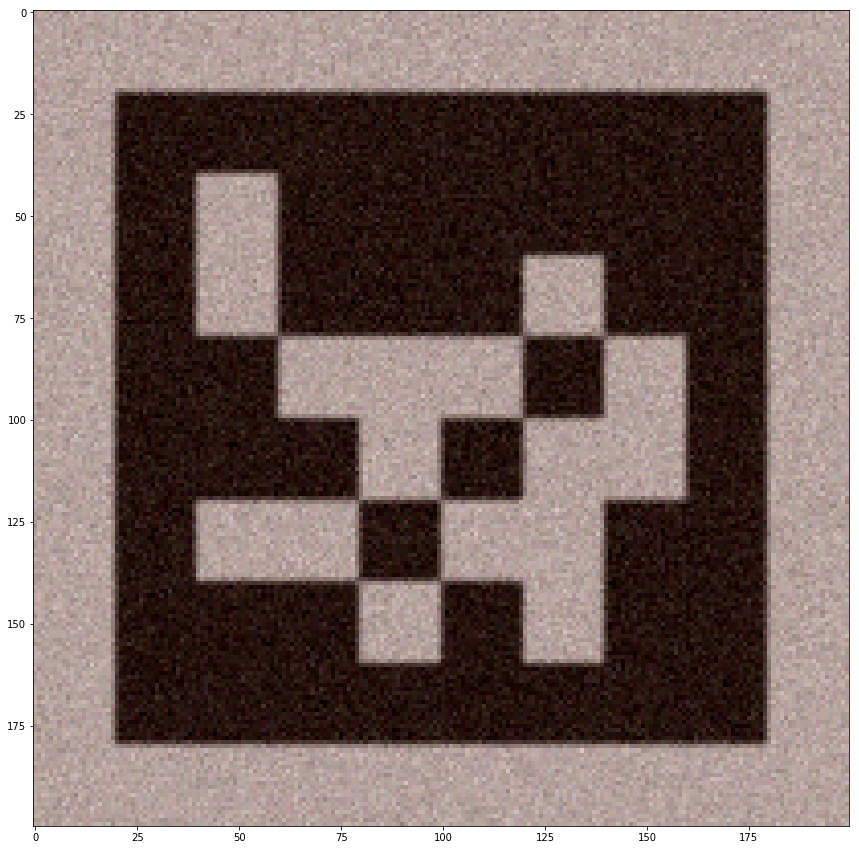

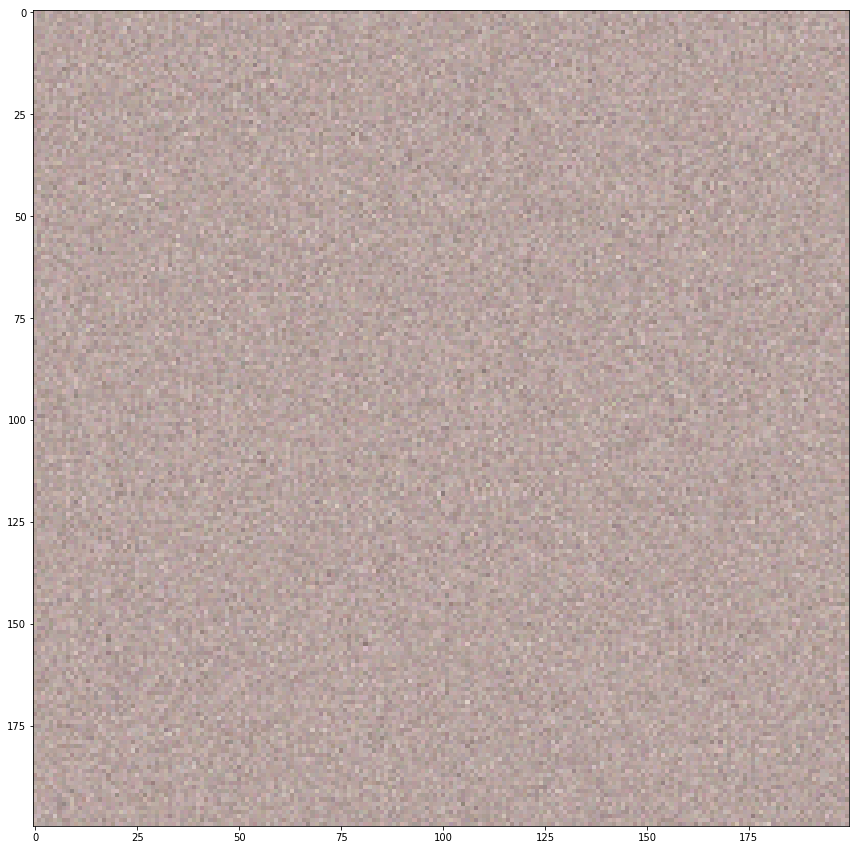

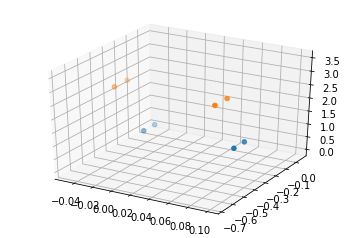

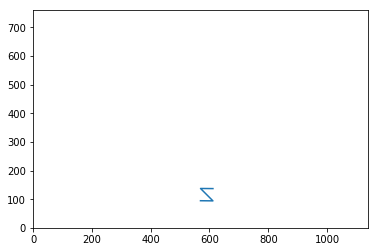

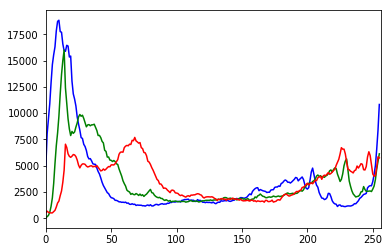

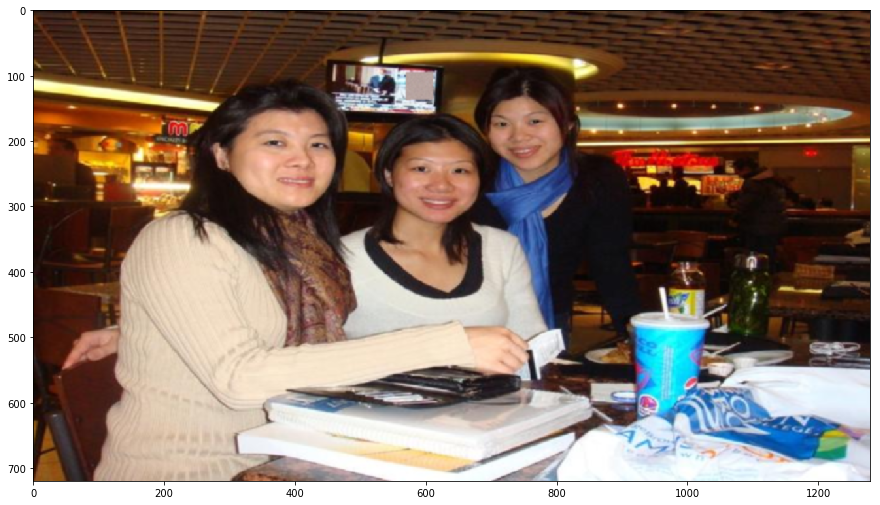

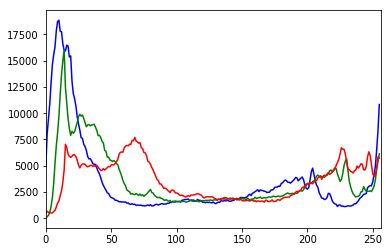

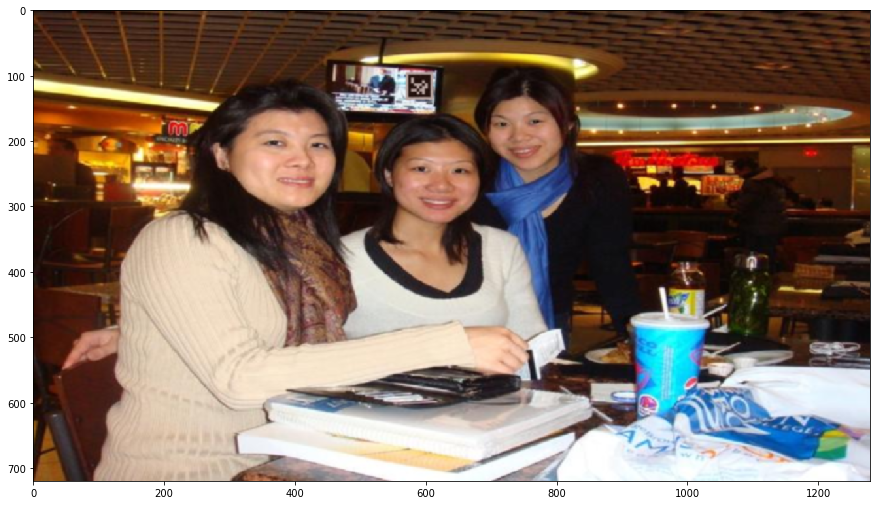

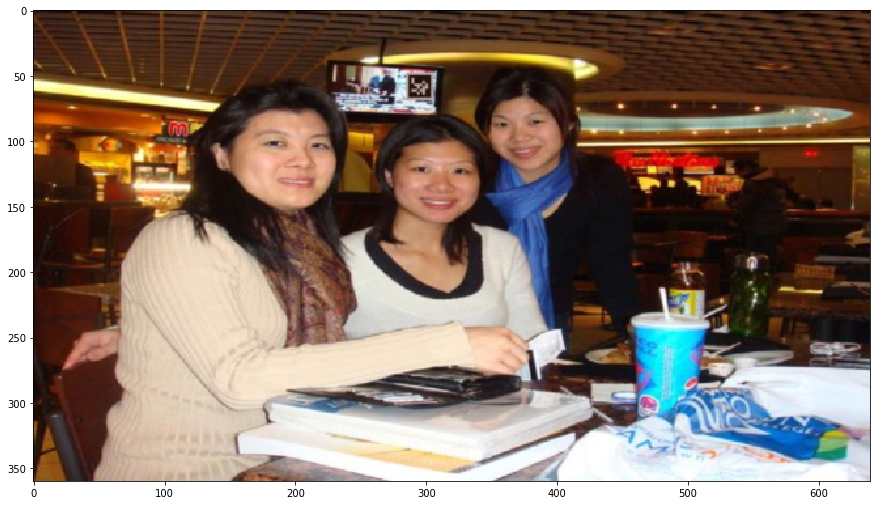

590.5712360303105 115.69694067584251 47.31271949388508 48.23012489043063


In [8]:
# Test for generating training sample

_, _, center_x, center_y, width, height = gen_sample(True)
print(center_x, center_y, width, height)
pass

In [9]:
global global_scene

# Helper for generating training/validation batches

def gen_samples(n, plot=False, include_neg=True, low_res=False):
    images = []
    labels = []
    for _ in range(n):
        neg, pos, center_x, center_y, width, height = gen_sample(plot, low_res)
        
        global global_scene
        global_scene = pos

        neg = neg.astype(np.float32)
        pos = pos.astype(np.float32)
        neg /= 255.0
        neg -= 0.5
        pos /= 255.0
        pos -= 0.5

        if include_neg:
            images.append(neg)
            labels.append([0, center_x, center_y, width, height])
        images.append(pos)
        labels.append([1, center_x, center_y, width, height])
        
    return np.asarray(images), np.asarray(labels).astype(np.float32)

In [10]:
from functools import partial
def cnn_model_fn(features, labels, mode):

    """Model function for CNN."""
    # Input Layer
    
    #######################################################33

    size = [360, 640]
    leaky_relu = partial(tf.nn.leaky_relu, alpha=0.01)

    input_layer = tf.image.resize_images(
                            features["x"],
                            size,
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR,
                            align_corners=False)

    #pool0 = tf.layers.max_pooling2d(inputs=input_layer, pool_size=[2, 2], strides=2)
    
    #print("features", features["x"].shape)
    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=leaky_relu)
    #print("conv1", conv1.shape)

    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    #print("pool1", pool1.shape)
    
    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=leaky_relu)

    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Convolutional Layer #3 and Pooling Layer #3
    conv3 = tf.layers.conv2d(
      inputs=pool2,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=leaky_relu)
    pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[4, 4], strides=4)

    # Convolutional Layer #4 and Pooling Layer #4
    conv4 = tf.layers.conv2d(
      inputs=pool3,
      filters=16,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.leaky_relu)
    pool4 = tf.layers.max_pooling2d(inputs=conv4, pool_size=[4, 4], strides=4)

#     print("pool4", pool4.shape)
    # Dense Layer
    
    #######################################################33
    # TODO fill in some_size
    flattened_conv = tf.contrib.layers.flatten(pool4)
    def fc_layer(inputs, units=512, dropout=False, batchnorm=False, activation=leaky_relu):
        out = tf.layers.dense(inputs=inputs, units=units, activation=activation)
        if batchnorm:
            out = tf.layers.batch_normalization(inputs=out, training=mode == tf.estimator.ModeKeys.TRAIN)
        if dropout:
            out = tf.layers.dropout(inputs=out, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
        return out

    classifier1 = fc_layer(flattened_conv, units=512, dropout=True, batchnorm=True)
    classifier2 = fc_layer(classifier1, units=256, dropout=True, batchnorm=True)
    classifier3 = fc_layer(classifier2, units=256, dropout=True, batchnorm=True)
    classifier4 = fc_layer(classifier3, units=1, dropout=False, batchnorm=False, activation=tf.nn.sigmoid)
    prob = tf.squeeze(classifier4, name="prob")

    bounding_box1 = fc_layer(flattened_conv, units=256, dropout=False, batchnorm=True)
    bounding_box2 = fc_layer(bounding_box1, units=256, dropout=False, batchnorm=True)
    #intersection = tf.concat([bounding_box2, classifier3], 1)
    bounding_box3 = fc_layer(bounding_box2, units=256, dropout=False, batchnorm=False)
    # center_x, center_y, width, height
    bounding_box4 = fc_layer(bounding_box3, units=4, dropout=False, batchnorm=False)
    bounding = bounding_box4
    
    # labels is: prob, center_x, center_y, width, height
    prob_labels = tf.add(0.0, labels[:,0], name="prob_labels")
    bounding_labels = labels[:,1:]
    prob_loss = tf.reduce_mean(tf.nn.relu((prob_labels - prob) ** 2 - 0.1 ** 2), name="prob_loss")

    bounding_loss_weight = tf.expand_dims(prob_labels * tf.nn.relu(prob - 0.6), axis=1)

    bounding_loss = bounding_loss_weight * (bounding_labels - bounding) ** 2
    #bounding_loss = (bounding_labels - bounding) ** 2
    bounding_loss = tf.reduce_mean(bounding_loss, name="bounding_loss") / 400 ** 2
    loss = tf.reduce_mean(prob_loss + bounding_loss, name="loss")
    predictions = {
      "predictions": tf.round(prob),
      "probabilities": prob
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return prob

    # # Calculate Loss (for both TRAIN and EVAL modes)
    # # Add a margin to the loss

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    
    # Saliency
    
    accuracy = tf.metrics.accuracy(
          labels=labels, predictions=predictions["predictions"], name="accuracy")
    
    saliency_grad = tf.gradients(logits, features["x"], name="saliency_grad")
#     saliency_grad = tf.gradients(logits, , name="saliency_grad")
    saliency_map = tf.squeeze(tf.reduce_max(tf.abs(saliency_grad), axis=4), name="saliency_map")

    eval_metric_ops = {"accuracy": accuracy}
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [11]:
global global_saliency_map

class SaliencyHook(tf.train.SessionRunHook):

  def __init__(self):
    return

  def begin(self):
    # Convert names to tensors
    #self._current_tensors = {tag: _as_graph_element(tensor)
    #                         for (tag, tensor) in self._tensors.items()}
    #self._saliency_map = [_as_graph_element("loss")]

    print("testtests")

  def before_run(self, run_context):
    return tf.train.SessionRunArgs({
        "saliency_map": _as_graph_element("saliency_map", run_context.session.graph)
    })

  def after_run(self, run_context, run_values):
    m = run_values.results["saliency_map"]
    m += np.min(m)
    m /= np.max(m)
    #print("fdafdsaf", m)
    global global_saliency_map
    global_saliency_map = m

#     print("HELLO")
# #     session = run_context.session
#     values = session.run(_as_graph_element("loss", session.graph))
#     print("here")
#     print(values)

def _as_graph_element(obj, graph):
  """Retrieves Graph element."""
  import six
  if not isinstance(obj, six.string_types):
    if not hasattr(obj, "graph") or obj.graph != graph:
      raise ValueError("Passed %s should have graph attribute that is equal "
                       "to current graph %s." % (obj, graph))
    return obj
  if ":" in obj:
    element = graph.as_graph_element(obj)
  else:
    element = graph.as_graph_element(obj + ":0")
    # Check that there is no :1 (e.g. it's single output).
    try:
      graph.as_graph_element(obj + ":1")
    except (KeyError, ValueError):
      pass
    else:
      raise ValueError("Name %s is ambiguous, "
                       "as this `Operation` has multiple outputs "
                       "(at least 2)." % obj)
  return element

In [12]:
print("Building estimator...", flush=True)
# Create the Estimator
classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir="./model_regression")

def train():

    tensors_to_log = {"loss": "loss", "prob_loss": "prob_loss", "bounding_loss": "bounding_loss", "prob": "prob", "prob_labels": "prob_labels"}
    logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=10)

    print("Training model...", flush=True)
    # Train the model
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": train_data},
      y=train_labels,
      batch_size=25,
      num_epochs=None,
      shuffle=False)

    classifier.train(
      input_fn=train_input_fn,
      steps=1,
      hooks=[logging_hook])
# train()

def eval():
    print("Evaluating model...", flush=True)
    # Evaluate the model and print results
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": eval_data},
      y=eval_labels,
      num_epochs=1,
      shuffle=False)
    saliency_hook = SaliencyHook()
    eval_results = classifier.evaluate(input_fn=eval_input_fn, hooks=[saliency_hook])
    print(eval_results)


Building estimator...


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_is_chief': True, '_task_type': 'worker', '_session_config': None, '_num_ps_replicas': 0, '_global_id_in_cluster': 0, '_model_dir': './model_regression', '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_steps': None, '_save_summary_steps': 100, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7efc86ae2978>, '_log_step_count_steps': 100, '_evaluation_master': '', '_master': '', '_task_id': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_num_worker_replicas': 1, '_save_checkpoints_secs': 600, '_service': None}


In [13]:

training_batches = []

need_data_cv = threading.Condition()
data_ready_cv = threading.Condition()
def worker():
    """ training data generator """
    print("Starting worker thread")
    while True:
        print("Waiting until new data is needed")
        need_data_cv.acquire()
        while len(training_batches) >= 2:
            need_data_cv.wait()
        need_data_cv.release()
        
        data_ready_cv.acquire()
        print("Generating new data")
        training_batches.append(gen_samples(25, low_res=True))
        data_ready_cv.notify()
        data_ready_cv.release()

threads = []
for i in range(2):
    thr = threading.Thread(target=worker)
    threads.append(thr)
    thr.start()

while True:
    print("Waiting for available data")
    data_ready_cv.acquire()
    while len(training_batches) == 0:
        data_ready_cv.wait()
    data_ready_cv.release()
    
    train_data, train_labels = training_batches.pop()
    print(train_data.shape)
    print(train_labels.shape)
    print("Training")
    need_data_cv.acquire()
    train()
    need_data_cv.notify()
    need_data_cv.release()

Starting worker thread
Waiting until new data is needed
Generating new data
Starting worker thread
Waiting until new data is needed
Waiting for available data
Waiting until new data is needed
Generating new data
Waiting until new data is needed
(50, 360, 640, 3)Generating new data

(50, 5)
Training
Training model...


INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use the retry module or similar alternatives.


TypeError: relu() got an unexpected keyword argument 'axis'

In [ ]:
import scipy.ndimage.filters

eval_data, eval_labels = gen_samples(1, plot=False, include_neg=False, low_res=True)
# global global_scene
# global_scene = cv2.resize(cv2.imread("eval/0.jpg"), (1280, 720), interpolation=cv2.INTER_NEAREST)
# global_scene = global_scene / 255.0
# global_scene = np.round(global_scene)
# global_scene = (global_scene * 255).astype(np.uint8)

eval_data = np.array([global_scene]).astype(np.float32)
#eval_labels = np.asarray([1.0])
print(type(eval_data))
print(eval_data.shape)
eval()

global global_scene
global global_saliency_map

smap_pooled = scipy.ndimage.filters.maximum_filter(global_saliency_map, size=(10,10))
smap_filtered = cv2.GaussianBlur(smap_pooled, (19, 19), 0)
smap_clipped = np.clip(np.round(smap_filtered), 0, 1)
smap_bool = smap_clipped > 0.5

coords = []
for y in range(smap_clipped.shape[0]):
    for x in range(smap_clipped.shape[1]):
        if smap_bool[y][x]:
            coords.append([x, y])
coords = np.array(coords).astype(np.float)

if False:
    
    if len(coords) == 0:
        # this is rare
        raise Exception("try again oops")

    std_dev = np.linalg.norm(np.std(coords, axis=0))
    m = np.median(coords,axis=0)

    new_coords = []
    for pair in coords:
        if np.linalg.norm(pair - m) < std_dev * 1.5:
            new_coords.append(pair)

    coords = np.asarray(new_coords)

    center_min = np.min(coords, axis=0)
    center_max = np.max(coords, axis=0)
    center = ((center_min + center_max) / 2.0).astype(np.int)
    size = (np.linalg.norm(center_max - center_min) / 2 * 1.2).astype(np.int)
    print(center_min)
    print(center_max)
    print(center)
    marked_scene = np.array(global_scene)
    # marked_scene[center] = [0, 255, 0]
    #cv2.circle(marked_scene, center, 63, (0,0,255))

    cv2.circle(marked_scene, tuple(center), size, (255, 0, 0), 5)
    show_cv2(marked_scene)
show_cv2(global_scene)
plt.figure(figsize=(15,15))
plt.imshow(smap_filtered, cmap="inferno")
plt.show()

print(np.max(global_saliency_map))
print(np.min(global_saliency_map))
#plt.figure(figsize=(15,15))
#plt.imshow(smap_clipped, cmap="inferno")
#plt.show()

# Create a black image
img = np.zeros((512,512,3), np.uint8)
print(global_saliency_map.shape)

# Draw a diagonal blue line with thickness of 5 px
global_saliency_map[:,:]=1

In [ ]:
# do some traditional cv stuff to located corners from our region proposal
# and compute world->tag transform with that